In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu

In [3]:
from keras.layers import Input, LSTM, Embedding, Dense,Flatten
from keras.models import Model
from keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

In [4]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_df=pd.read_csv('/content/drive/MyDrive/ Machine_translation/procedded_data.csv')
train_df.head()

,source,encoder_input,decoder_input,decoder_output
0,ted,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...
1,ted,<start> i would like to tell you about one suc...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,<start> this percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक ह...
3,ted,<start> what we really mean is that they are b...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते...
4,indic2012,<start> the ending portion of these vedas is c...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है <en...


In [7]:
train_df['encoder_input'][1:2]

1    <start> i would like to tell you about one suc...
Name: encoder_input, dtype: object

In [8]:
train_df.shape

(127607, 4)

In [9]:
train_df['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [11]:
def find_length(sentence):
    return len(sentence.split())

In [12]:
train_df['len_encoder_input'] = train_df['encoder_input'].apply(find_length)
train_df['len_decoder_input'] = train_df['decoder_input'].apply(find_length)

In [13]:
train_df.head()

,source,encoder_input,decoder_input,decoder_output,len_encoder_input,len_decoder_input
0,ted,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...,14,15
1,ted,<start> i would like to tell you about one suc...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,12,13
2,indic2012,<start> this percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक ह...,12,11
3,ted,<start> what we really mean is that they are b...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते...,15,13
4,indic2012,<start> the ending portion of these vedas is c...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है <en...,11,10


In [14]:
max_len_eng = 12  
max_len_eng

12

In [15]:
max_len_hindi =14 
max_len_hindi

14

In [16]:
train_df=train_df[train_df['len_encoder_input']<=max_len_eng]
train_df.shape

(57983, 6)

In [17]:
train_df=train_df[train_df['len_decoder_input']<=max_len_hindi]
train_df.shape

(53868, 6)

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df, test_size=0.15,random_state=42)
train.shape,test.shape

((45787, 6), (8081, 6))

In [19]:
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['encoder_input'].values)

vocab_size_eng = len(tknizer_eng.word_index) + 1
vocab_size_eng,max_len_eng

(21760, 12)

In [20]:
tknizer_hindi = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_hindi.fit_on_texts(train['decoder_input'].values)

vocab_size_hindi = len(tknizer_hindi.word_index) + 1
vocab_size_hindi,max_len_hindi

(23096, 14)

In [21]:
tknizer_eng.word_index['<start>'],tknizer_eng.word_index['<end>']

(1, 2)

In [22]:
tknizer_eng.index_word[1],tknizer_eng.index_word[2]

('<start>', '<end>')

In [23]:
X_train_e=tknizer_eng.texts_to_sequences(train['encoder_input'])
X_train_h=tknizer_hindi.texts_to_sequences(train['decoder_input'])
y_train_h=tknizer_hindi.texts_to_sequences(train['decoder_output'])

X_test_e=tknizer_eng.texts_to_sequences(test['encoder_input'])
X_test_h=tknizer_hindi.texts_to_sequences(test['decoder_input'])
y_test_h=tknizer_hindi.texts_to_sequences(test['decoder_output']) 

In [24]:
X_train_e=pad_sequences(X_train_e,maxlen=max_len_eng,padding='post')
X_train_h=pad_sequences(X_train_h,maxlen=max_len_hindi,padding='post')
y_train_h=pad_sequences(y_train_h,maxlen=max_len_hindi,padding='post')

X_test_e=pad_sequences(X_test_e,maxlen=max_len_eng,padding='post')
X_test_h=pad_sequences(X_test_h,maxlen=max_len_hindi,padding='post')
y_test_h=pad_sequences(y_test_h,maxlen=max_len_hindi,padding='post') 

In [25]:
X_train_e.shape,X_train_h.shape,y_train_h.shape,X_test_e.shape,X_test_h.shape,y_test_h.shape

((45787, 12), (45787, 14), (45787, 14), (8081, 12), (8081, 14), (8081, 14))

In [26]:
print(X_train_e.shape)
X_train_e

(45787, 12)


array([[   1,    6,   14, ...,    2,    0,    0],
       [   1,  333,  453, ...,    0,    0,    0],
       [   1, 3734,   43, ..., 4239,    2,    0],
       ...,
       [   1,   13,   58, ...,    0,    0,    0],
       [   1,   24,    3, ...,    0,    0,    0],
       [   1,   30,   96, ...,    0,    0,    0]], dtype=int32)

In [27]:
print(X_train_h.shape)
X_train_h

(45787, 14)


array([[   1,    4,  275, ...,    0,    0,    0],
       [   1, 5704,  385, ...,    0,    0,    0],
       [   1,  905,    5, ...,    0,    0,    0],
       ...,
       [   1,   11,  124, ...,    0,    0,    0],
       [   1,  789,    4, ...,    0,    0,    0],
       [   1,   95,   14, ...,    0,    0,    0]], dtype=int32)

In [28]:
y_train_h

array([[   4,  275,  628, ...,    0,    0,    0],
       [5704,  385, 2120, ...,    0,    0,    0],
       [ 905,    5,  405, ...,    0,    0,    0],
       ...,
       [  11,  124,   11, ...,    0,    0,    0],
       [ 789,    4, 1616, ...,    0,    0,    0],
       [  95,   14,   23, ...,    0,    0,    0]], dtype=int32)

In [29]:
def generate_batch(X_e,X_h,y_h,batch_size):
    while True:
        for i in range(0,X_e.shape[0]//batch_size):
            encoder_input = X_e[i*batch_size:(i+1)*batch_size]
            decoder_input = X_h[i*batch_size:(i+1)*batch_size]
            decoder_output_= y_h[i*batch_size:(i+1)*batch_size]
            decoder_output=np.zeros((batch_size,max_len_hindi,vocab_size_hindi))
            for i in range(batch_size):
                for j in range(max_len_hindi):
                    k=decoder_output_[i][j]
                    if k!=0:
                        decoder_output[i][j][k]=1
                    else:
                        continue
            yield([encoder_input, decoder_input], decoder_output)    

In [30]:
#early stopping
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,verbose=1,mode='min')

In [31]:
class LossHistory(callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'val_loss': []}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
            
history_own=LossHistory()   

In [32]:
from keras.callbacks import LearningRateScheduler
def changeLearningRate(epoch,lr):
    if len(history_own.history['val_loss'])>1: #check if there there two elements   
        if(history_own.history['val_loss'][-1] > history_own.history['val_loss'][-2]): #check if loss is more than previous log loss
            return(lr-(0.1*lr))                               #if true reduce learning rate
    if ((epoch+1)%10)==0 and epoch!=0:   #reduce learning rate for every 10th epoch
        return(lr-(0.05*lr))
    else:
        return lr
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

In [33]:
callback_list = [history_own,earlystop,lrschedule] 

In [34]:
embedding_dim=150
lstm_units=100
batch_size=64

In [35]:
# Encoder
# encoder_inputs = Input(batch_shape=(batch_size,max_len_eng))
encoder_inputs = Input(shape=(None,),name='Encoder_input')
print('Encoder input : ',encoder_inputs.shape)
enc_emb =  Embedding(vocab_size_eng,embedding_dim,name='Encoder_embedding_layer')(encoder_inputs)
print('Encoder after embedding layer : ',enc_emb.shape)
encoder_lstm = LSTM(lstm_units, return_state=True,name='Encoder_lstm_layer')
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
print('Encoder output after lstm : ',encoder_outputs.shape)
print('Encoder state_h after lstm : ',state_h.shape)
print('Encoder state_c after lstm : ',state_c.shape)
print('-'*40)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Encoder input :  (None, None)
Encoder after embedding layer :  (None, None, 150)
Encoder output after lstm :  (None, 100)
Encoder state_h after lstm :  (None, 100)
Encoder state_c after lstm :  (None, 100)
----------------------------------------


In [36]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name='Decoder_input')
print('Decoder inputs : ',decoder_inputs.shape)
dec_emb_layer = Embedding(vocab_size_hindi,embedding_dim,name='Decoder_embedding_layer')
dec_emb = dec_emb_layer(decoder_inputs)
print('Decoder after embedding layer : ',dec_emb.shape)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,name='Decoder_lstm_layer')
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
print('Decoder outputs after lstm : ',decoder_outputs.shape)
decoder_dense = Dense(vocab_size_hindi, activation='softmax',name='Decoder_dense_layer')
decoder_outputs = decoder_dense(decoder_outputs)
print('Decoder outputs after dense layer : ',decoder_outputs.shape)
print('-'*40)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Decoder inputs :  (None, None)
Decoder after embedding layer :  (None, None, 150)
Decoder outputs after lstm :  (None, None, 100)
Decoder outputs after dense layer :  (None, None, 23096)
----------------------------------------


In [37]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_embedding_layer (Embedd (None, None, 150)    3264000     Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_embedding_layer (Embedd (None, None, 150)    3464400     Decoder_input[0][0]              
______________________________________________________________________________________________

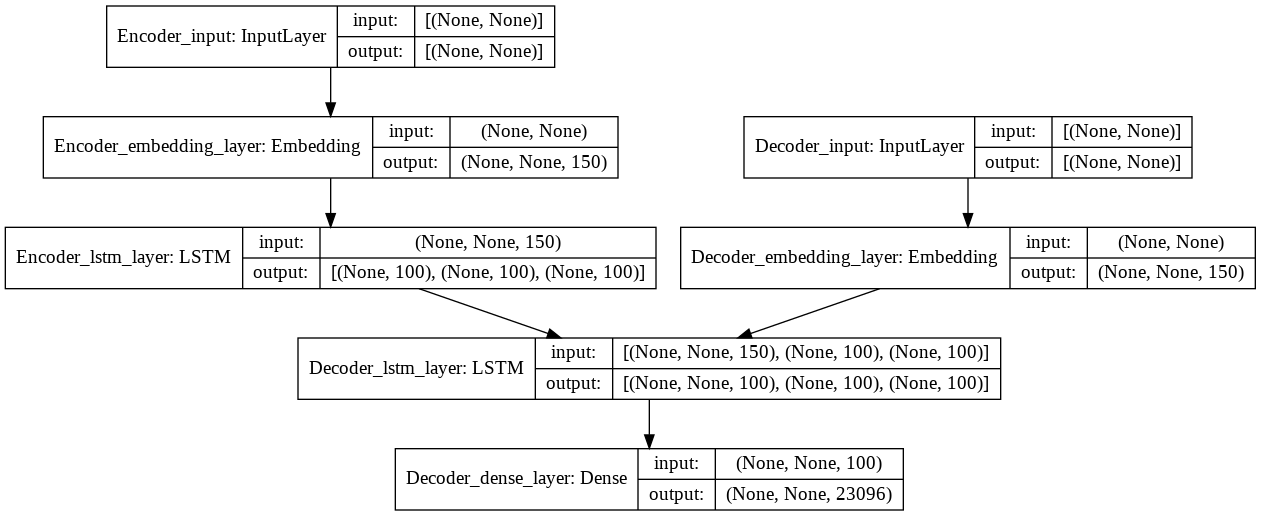

In [39]:
plot_model(model,'model_encoder_decoder.png',show_shapes=True)

In [40]:
train_samples = len(X_train_e)
val_samples = len(X_test_e)
epochs = 200

In [41]:
model.fit_generator(generator = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test_e,X_test_h,y_test_h, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,callbacks=callback_list)

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
715/715 [==============================] - 95s 109ms/step - loss: 3.9536 - val_loss: 3.2731
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
715/715 [==============================] - 76s 107ms/step - loss: 3.4034 - val_loss: 3.0285
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
715/715 [==============================] - 77s 108ms/step - loss: 3.1214 - val_loss: 2.8954
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
715/715 [==============================] - 76s 106ms/step - loss: 2.9516 - val_loss: 2.8144
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
715/715 [==============================] - 76s 107ms/step - loss: 2.8332 - val_loss: 2.7586
Epoch 6/200

Epoch 00006: LearningRateScheduler reducin

In [42]:
model.save_weights('/content/drive/MyDrive/ Machine_translation/encoder_decoder_weights_200e.h5')

In [43]:
model.load_weights('/content/drive/MyDrive/ Machine_translation/encoder_decoder_weights_200e.h5')

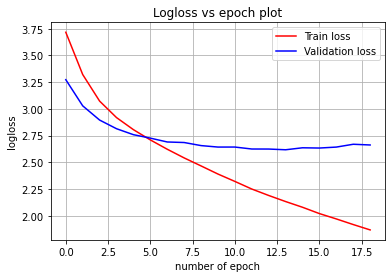

In [44]:
plt.plot(history_own.history['loss'], 'r')
plt.plot(history_own.history['val_loss'], 'b')
plt.legend({'Train loss': 'r', 'Validation loss':'b'})
plt.ylabel('logloss')
plt.xlabel('number of epoch')
plt.title('Logloss vs epoch plot')
plt.grid()
plt.show()

In [45]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
 
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(lstm_units,),name='Decoder_state_h')
decoder_state_input_c = Input(shape=(lstm_units,),name='Decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [46]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
Encoder_embedding_layer (Emb (None, None, 150)         3264000   
_________________________________________________________________
Encoder_lstm_layer (LSTM)    [(None, 100), (None, 100) 100400    
Total params: 3,364,400
Trainable params: 3,364,400
Non-trainable params: 0
_________________________________________________________________


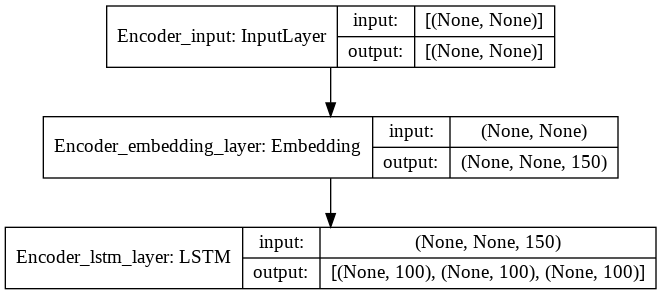

In [47]:
plot_model(encoder_model,'model_encoder_decoder.png',show_shapes=True)

In [48]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_embedding_layer (Embedd (None, None, 150)    3464400     Decoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_state_h (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
Decoder_state_c (InputLayer)    [(None, 100)]        0                                            
____________________________________________________________________________________________

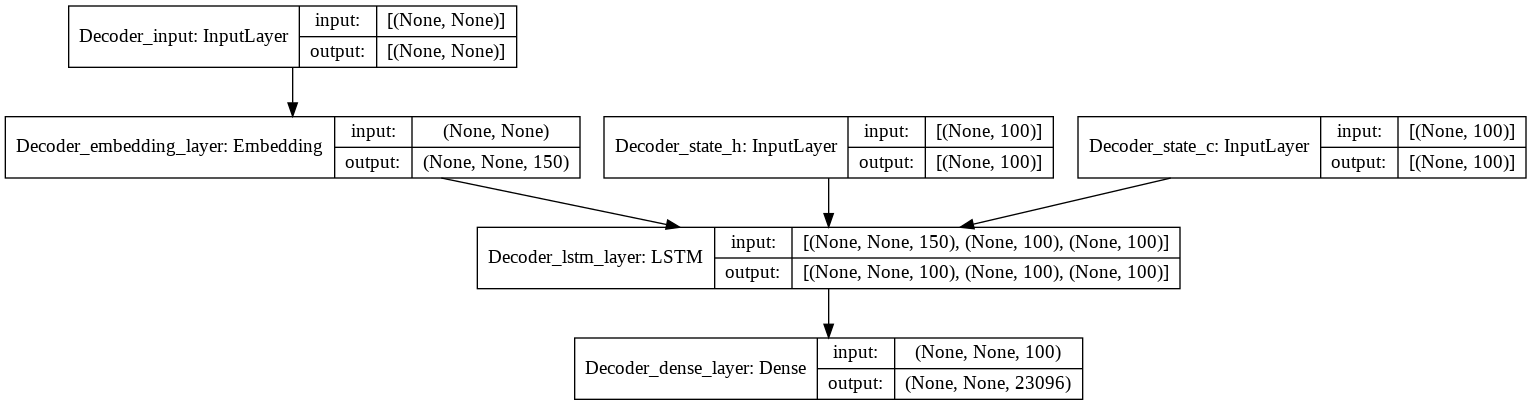

In [49]:
plot_model(decoder_model,'model_encoder_decoder.png',show_shapes=True)

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tknizer_hindi.word_index['<start>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tknizer_hindi.index_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<end>'):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [51]:
def index_to_text(x,dictionary):#convert id to word
    s=''
    for i in x[0]:
        if i==0:
            break
        if dictionary[i]=='<end>' or dictionary[i]=='<start>':
            continue
        s+=dictionary[i]+' '
    return s

## Sample output on Train Data

In [76]:
train_gen = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = 1)

In [77]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  and you go outside into the real world 
Actual Hindi Translation:  के बाहर असली दुनिया में आते है 
Predicted Hindi Translation:  और आप दुनिया में एक समस्या करते हैं <end>
BLEU Score :  0.43472087194499137


In [78]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  international ramayana institute north america 
Actual Hindi Translation:  अन्तरराष्ट्रीय रामायण संस्थान उत्तरी अमेरिका 
Predicted Hindi Translation:  रामायण पाठ महाभारत का इतिहास <end>
BLEU Score :  0.668740304976422


In [79]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  kuraan has totally chapters which are called as sura 
Actual Hindi Translation:  क़ुरान में कुल अध्याय हैं जिन्हें सूरा कहते हैं 
Predicted Hindi Translation:  गंगा की राजधानी है कि यह कहते हैं <end>
BLEU Score :  0.38363982298032945


In [80]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  point source dispersion is used for industrial sources 
Actual Hindi Translation:  स्रोत प्वाइंट point sourcedispersion औद्योगिक सूत्रों के लिए प्रयोग किया जाता है 
Predicted Hindi Translation:  स्रोत रेणु पोजीशन दृष्टि में भी क्या होता है <end>
BLEU Score :  0.4919625503668659


In [81]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  with low probability events 
Actual Hindi Translation:  एक अंदरूनी समस्या हैं 
Predicted Hindi Translation:  एक और विकास के रूप में <end>
BLEU Score :  0.6389431042462724


In [82]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  salux nnactor was next powerful precedeer of sikondor 
Actual Hindi Translation:  सेल्युकस नेक्टर सिकन्दर के सबसे शक्तिशाली उत्तराधिकारियों में से एक था 
Predicted Hindi Translation:  यार्क यदि विश्व धरोहर स्थल धरोहर है <end>
BLEU Score :  0


In [83]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  we have hobby of seeing testing limits of powers 
Actual Hindi Translation:  हमें यह शौक है देखें सितम की इंतहा क्या है 
Predicted Hindi Translation:  हम इस प्रकार की कोशिकाओं का आंकलन करने की जरूरत है <end>
BLEU Score :  0.6529942057256104


In [84]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he has been always associated with akbar 
Actual Hindi Translation:  इनके अकबर के संग किस्से आज भी कहे जाते हैं 
Predicted Hindi Translation:  वे अपने न्यायालय का और कमजोर रोग है <end>
BLEU Score :  0


In [85]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  and playing a car racing game 
Actual Hindi Translation:  और आप एक कार रेसिंग गेम खेल रहे हैं 
Predicted Hindi Translation:  और एक एक एक दोस्त बनाने के लिए <end>
BLEU Score :  0.6240195441936915


In [86]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  like with a pacemaker 
Actual Hindi Translation:  जैसे कि गतिनिर्धारक से 
Predicted Hindi Translation:  एक एक विश्लेषण के लिए <end>
BLEU Score :  0


## Sample output on CV Data

In [87]:
test_gen = generate_batch(X_test_e,X_test_h,y_test_h, batch_size = 1)

In [88]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  poets polite saint pant 
Actual Hindi Translation:  कवियों के सौम्य संत पंत 
Predicted Hindi Translation:  भक्त जिला <end>
BLEU Score :  0


In [89]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  there is no dearth for artists 
Actual Hindi Translation:  यहां कला प्रेमियों की कमी भी नहीं है 
Predicted Hindi Translation:  इनके नाम के लिए कोई गिनती है <end>
BLEU Score :  0.5329462628216854


In [90]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  again there was heavy battle in two parties 
Actual Hindi Translation:  फिर से दोनों पक्षो में बड़ा भयंकर युद्ध हुआ 
Predicted Hindi Translation:  इन साल में एक कंपनी की मृत्यु थे <end>
BLEU Score :  0.5247357977607321


In [91]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  now i do not mean to mock 
Actual Hindi Translation:  मैं नहीं होना चाहता 
Predicted Hindi Translation:  अब मैं एक बात नहीं हूँ <end>
BLEU Score :  0.7598356856515925


In [92]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  at the beginning in there was small faces 
Actual Hindi Translation:  आरंभ में मक्के में छोटी छोटी सूरतें अवतीर्ण हुईं 
Predicted Hindi Translation:  एक तरह में एक टोपी बना रहे हैं <end>
BLEU Score :  0.5247357977607321


In [93]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  in thumb 
Actual Hindi Translation:  में thumb 
Predicted Hindi Translation:  में <end>
BLEU Score :  0.36787944117144233


In [94]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  pratahkal hindi news the intended news 
Actual Hindi Translation:  pratahkal hindi news paper प्रातःकाल में हिन्दी न्यूज़ सर्च करें 
Predicted Hindi Translation:  हिन्दी प्रकाशक लामा हिन्दी <end>
BLEU Score :  0.15777684932819508


In [95]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  i will craft my own drum 
Actual Hindi Translation:  मेरा मैं ख़ुद 
Predicted Hindi Translation:  मैं अपनी study लड़कियों के लिए मैं रिहा कर रहे हैं <end>
BLEU Score :  0.5491004867761125


In [96]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  thank you 
Actual Hindi Translation:  धन्यवाद 
Predicted Hindi Translation:  धन्यवाद <end>
BLEU Score :  1.0


In [97]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  vedic 
Actual Hindi Translation:  वेद विद्या डॉट कॉम 
Predicted Hindi Translation:  वैदिक <end>
BLEU Score :  0
